# A database for a time-domain survey


In [12]:
import sys # remove at end of project
import numpy as np
import sqlite3 as lite
from astropy.table import Table
from astropy.io import fits
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['axes.labelsize'] = 13

%matplotlib inline

In [2]:
# Reading in the info table
infofiledir = 'Tables/file_info_for_problem.csv'
#infotab = np.loadtxt(infofiledir, delimiter=',',dtype='string')
infotab = Table.read(infofiledir, format='csv')

# The filenames in "file_info_for_problem.csv" have a different format than the 
# filenames of the test data we were given. In order to use this test data we need
# to know the 'real' filenames. Below, a row with the filenames is added (filename_new)
# to the information table so that these filenames can be used to extract data from the 
# test files. 
Ks_counter = 0
newnames = []
for i, name in enumerate(infotab['Filename']):
    field = infotab['FieldID'][i]
    if i > 0 and field != infotab['FieldID'][i-1]:
        Ks_counter = 0
    band = name[:2].replace('-','') 
    newname = 'Field-'+str(field)+'-'+band
    if 'Ks' in band: 
        Ks_counter += 1
        newname = newname + '-E' + format(Ks_counter, "03")
    newname = newname+'.fits'
    newnames.append(newname)
infotab['Filename_new'] = newnames

#print infotab
infotab.pprint(max_width=-1, max_lines=20)

 ID FieldID               Filename               Filter      MJD      Airmass Exptime     Filename_new    
--- ------- ------------------------------------ ------ ------------- ------- ------- --------------------
  1       1   Z-ADP.2017-01-18T11:58:36.905.fits      Z 57267.1671072  1.6405    40.0       Field-1-Z.fits
  2       1   J-ADP.2017-01-18T11:58:35.781.fits      J 57257.0504323  1.0105    48.0       Field-1-J.fits
  3       1   H-ADP.2017-01-18T11:58:35.780.fits      H  57257.044108   1.006    16.0       Field-1-H.fits
  4       1  Ks-ADP.2016-05-25T15:33:39.546.fits     Ks  56788.346937   1.023    16.0 Field-1-Ks-E001.fits
  5       1  Ks-ADP.2017-01-18T11:58:39.907.fits     Ks 56561.0020158   1.079    16.0 Field-1-Ks-E002.fits
  6       1  Ks-ADP.2016-05-25T15:33:43.377.fits     Ks 56829.0390512  1.6085    16.0 Field-1-Ks-E003.fits
  7       1   Y-ADP.2017-01-18T11:58:36.901.fits      Y 57267.1596647  1.5605    40.0       Field-1-Y.fits
  8       2  Z-ADP.2017-01-18T11:58:3

In [3]:
# Function used to create the database:
# (Only in a function so I don't accidentally re-run the code
# because I don't want to recreate the entire database by accident, 
# even though it's not that big)

def createdatabase():

    # Connect to database
    con = lite.connect('Database_Q1_cbrand.db')

    # Creating and filling the tables in the database:

    with con: 

        # ---------------- Creation of 7 tables below -------------------:

        # 1) The table that contains the observational info (ObsInfo)
        # ObsInfo Schema:
        ObsInfo_schema = """
                            CREATE TABLE ObsInfo (FieldID INT, Filter varchar(2), MJD DOUBLE, 
                            Filename varchar(40), 
                            UNIQUE(FieldID, Filter, MJD),
                            PRIMARY KEY(FieldID, Filter, MJD))
                         """
        # Drop if the table already exists so that changes can be made
        con.execute('DROP TABLE IF EXISTS ObsInfo')
        # Create the ObsInfo table:
        con.execute(ObsInfo_schema)

        # 2) The 5 tables that have the object data in the Z, Y, J, H and Ks filter (Data{Filter})
        tablenames = ['DataZ', 'DataY', 'DataJ', 'DataH', 'DataKs']

        for name in tablenames:
            # Data{Filter} Schema
            Data_schema = """
                            CREATE TABLE {} (StarID INT, MJD DOUBLE, 
                            Ra DOUBLE, Dec DOUBLE, X DOUBLE, Y DOUBLE, 
                            Flux1 DOUBLE, dFlux1 DOUBLE, Flux2 DOUBLE, dFlux2 DOUBLE,
                            Flux3 DOUBLE, dFlux3 DOUBLE, Class INT,
                            Mag1 DOUBLE, dMag1 DOUBLE, Mag2 DOUBLE, dMag2 DOUBLE, 
                            Mag3 DOUBLE, dMag3 DOUBLE,
                            UNIQUE(StarID, MJD),
                            PRIMARY KEY(StarID, MJD), 
                            FOREIGN KEY(StarID) REFERENCES StarFields(StarID))
                         """.format(name)
            # Drop if the table already exists so that changes can be made
            con.execute('DROP TABLE IF EXISTS {}'.format(name))
            con.execute(Data_schema)

        # 3) The table that contains info on which star is in which field (StarFields)
        # StarFields Schema:
        StarFields_schema = "CREATE TABLE StarFields (StarID INT, FieldID INT, UNIQUE(StarID), PRIMARY KEY(StarID))"
        con.execute('DROP TABLE IF EXISTS StarFields')
        con.execute(StarFields_schema)

        # ---------------- Filling of 7 tables below -------------------:

        # 1) Filling the table that contains the observational info (ObsInfo)
        # This only uses information from the file  "file_info_for_problem.csv"

        # Stack all data that we need to fill the table
        alldata_ObsInfo = np.column_stack((infotab['FieldID'], infotab['Filter'], 
                                          infotab['MJD'], infotab['Filename']))
        # Command to fill the table:
        FillObsInfo = "INSERT INTO ObsInfo VALUES (?, ?, ?, ?)"
        # Execute command
        con.executemany(FillObsInfo, alldata_ObsInfo)

        # 2) Filling the 5 tables that have the object data in the Z, Y, J, H and Ks filter (Data{Filter})
        # Only MJD is taken from the infotab table, the rest is image star data
        # MJD (the time) is taken from the information table "file_info_for_problem.csv", 
        # The rest of the data (object data) is taken from the fits files.

        # To save the unique StarIDs and FieldIDs to fill StarFields (see (3) below), create a dict
        fieldsdict = {}

        # Loop through all the available test data:
        for i, filename in enumerate(infotab['Filename_new']):

            # Open catalogue corresponding to data file 'filename':
            star_data = fits.open('Tables/'+filename)[1].data

            # Create a list of MJDs for the data file (MJD is the same for each star 
            # in one catalogue)
            MJD_list = [infotab['MJD'][i]]*len(star_data['StarID'])

            # Name of the table to fill (depends on the filter of the observation!)
            tablename = 'Data'+infotab['Filter'][i]

            # Combine all the data from the fits file that we need to put in the table
            alldata = np.column_stack((star_data['StarID'], MJD_list,
                                        star_data['Ra'], star_data['Dec'], 
                                        star_data['X'], star_data['Y'], 
                                        star_data['Flux1'], star_data['dFlux1'], 
                                        star_data['Flux2'], star_data['dFlux2'],
                                        star_data['Flux3'], star_data['dFlux3'], 
                                        star_data['Class'], 
                                        star_data['Mag1'], star_data['dMag1'], 
                                        star_data['Mag2'], star_data['dMag2'], 
                                        star_data['Mag3'], star_data['dMag3'] ))

            # Command to fill the Data table:
            FillData = """
                        INSERT INTO {0} VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
                                               ?, ?, ?, ?, ?, ?, ?, ?, ?)
                       """.format(tablename)

            # Execute command
            con.executemany(FillData, alldata)

            # To save the unique StarIDs and FieldIDs, put the StarIDs and FieldIDs in a dict 
            # in each loop (this will result in unique StarIDs, as they are the keys in the dict)
            fieldID_list = [infotab['FieldID'][i]]*len(star_data['StarID'])
            for key in star_data['StarID']:
                fieldsdict[key] = infotab['FieldID'][i]

        # 3) Filling the table StarFields with StarIDs and FieldIDs
        # The dictionary of unique StarIDs and corresponding FieldIDs was already filled
        # in the loop above, as we had to loop through all the files to fill the Data tables
        # anyway, otherwise we'd need to loop throught all the files again. 
        FillStarFields = "INSERT INTO StarFields VALUES(?, ?)"
        con.executemany(FillStarFields, np.column_stack((fieldsdict.keys(), fieldsdict.values())).astype(int)) 

        # TEST, REMOVE IT!!
        #test = con.execute('SELECT * from StarFields ORDER BY StarID')
        #for row in test:
            #print row

        #data = np.array(test.fetchall())

        #print data.shape
        #print len(data[:,0])
        #print len(np.unique(data[:,0]))
    con.close()

In [4]:
#createdatabase()

In [4]:
# # Close the connection 
# con.close()
# Open connec again:
con = lite.connect('Database_Q1_cbrand.db')

# Some testing to see if the database really contains what I want:

# res = con.execute("SELECT name FROM sqlite_master WHERE type='table'")
# print ' Tables in the database:'
# for row in res: 
#     print row[0]
    
# res = con.execute("SELECT * from ObsInfo")
# print '\n Columns in obsinfo'
# for row in res.description:
#     print row[0]
    
# res = con.execute("SELECT * from DataZ")
# print '\n Columns in DataZ'
# for row in res.description:
#     print row[0]

# res = con.execute("SELECT * from StarFields")
# print '\n Columns in StarFields'
# for row in res.description:
#     print row[0]

# print '\n Values in Dataz'
# res = con.execute("SELECT * FROM DataZ")
# for i, row in enumerate(res):
#     print i, row
#     if i == 5: break

# print '\n Values in ObsInfo'
# res = con.execute("SELECT * FROM ObsInfo")
# for i, row in enumerate(res):
#     print i, row
#     if i == 5: break
        
# print '\n Values in StarFields'
# res = con.execute("SELECT * FROM StarFields")
# for i, row in enumerate(res):
#     print i, row
#     if i == 5: break
      

In [5]:
#R1:  Find all images observed between MJD=56800 and MJD=57300 and give me the number of
#     stars detected with S/N > 5 in each image. 

print 'Python + SQL result:'
r10 = "SELECT * from ObsInfo WHERE MJD > 56800 AND MJD < 57300 ORDER BY MJD"
r10ex = con.execute(r10)
# NOTE: sort data info by measurement time?
for row in r10ex:
    # calc number of stars with S/N > 5 for each image
    # time interval already satisfied but do again
    r11 = """   SELECT COUNT(*) FROM Data{0} AS dat, StarFields
                WHERE dat.StarID == StarFields.StarID
                AND dat.Class == -1
                AND StarFields.FieldID == {1}
                AND dat.MJD == {2}
                AND (dat.Flux1/dat.dFlux1) > 5
                ORDER BY MJD
            """.format(row[1], row[0], row[2])
#     r11 = """   SELECT COUNT(*) FROM data_{0} AS dat, fields
#                 WHERE dat.StarID == fields.StarID
#                 AND dat.Class == -1
#                 AND dat.MJD == {1}
#                 AND (dat.Flux1/dat.dFlux1) > 5
#             """.format(row[1], row[2])
    r11ex = con.execute(r11)
    r11res = r11ex.fetchall()
    print 'Filename: ', row[3], ', MJD: ', row[2], '#stars:', r11res[0][0]
    #print 'Filename: ', row[3], ', MJD: ', row[2], len(r11res) #same as above

# Works, but too much python!

# This query selects the same, but using only SQL
# It is quite long, because I have to union the results from the 5 different 
# tables DataZ, DataY, DataJ, DataH and DataKs


r1 = """ SELECT fn, mjd, numstars FROM (

        SELECT ObsInfo.Filename as fn, ObsInfo.MJD as mjd, COUNT(dat.StarID) as numstars 
        FROM DataZ AS dat, ObsInfo, StarFields
        WHERE dat.StarID == StarFields.StarID
        AND dat.MJD == ObsInfo.MJD
        AND StarFields.FieldID == ObsInfo.FieldID
        AND dat.Class == -1
        AND (dat.Flux1/dat.dFlux1) > 5
        GROUP BY ObsInfo.Filename
        
        UNION
        
        SELECT ObsInfo.Filename as fn, ObsInfo.MJD as mjd, COUNT(dat.StarID) as numstars 
        FROM DataY AS dat, ObsInfo, StarFields
        WHERE dat.StarID == StarFields.StarID
        AND dat.MJD == ObsInfo.MJD
        AND StarFields.FieldID == ObsInfo.FieldID
        AND dat.Class == -1
        AND (dat.Flux1/dat.dFlux1) > 5
        GROUP BY ObsInfo.Filename 
        
        UNION
        
        SELECT ObsInfo.Filename as fn, ObsInfo.MJD as mjd, COUNT(dat.StarID) as numstars 
        FROM DataJ AS dat, ObsInfo, StarFields
        WHERE dat.StarID == StarFields.StarID
        AND dat.MJD == ObsInfo.MJD
        AND StarFields.FieldID == ObsInfo.FieldID
        AND dat.Class == -1
        AND (dat.Flux1/dat.dFlux1) > 5
        GROUP BY ObsInfo.Filename
        
        UNION
        
        SELECT ObsInfo.Filename as fn, ObsInfo.MJD as mjd, COUNT(dat.StarID) as numstars 
        FROM DataH AS dat, ObsInfo, StarFields
        WHERE dat.StarID == StarFields.StarID
        AND dat.MJD == ObsInfo.MJD
        AND StarFields.FieldID == ObsInfo.FieldID
        AND dat.Class == -1
        AND (dat.Flux1/dat.dFlux1) > 5
        GROUP BY ObsInfo.Filename
        
        UNION
        
        SELECT ObsInfo.Filename as fn, ObsInfo.MJD as mjd, COUNT(dat.StarID) as numstars 
        FROM DataKs AS dat, ObsInfo, StarFields
        WHERE dat.StarID == StarFields.StarID
        AND dat.MJD == ObsInfo.MJD
        AND StarFields.FieldID == ObsInfo.FieldID
        AND dat.Class == -1
        AND (dat.Flux1/dat.dFlux1) > 5
        GROUP BY ObsInfo.Filename
        
        )
        WHERE mjd BETWEEN 56800 AND 57300
        ORDER BY mjd
     """
r1ex = con.execute(r1)
print 'SQL only result:'
for row in r1ex:
    #print 'Filename: ', row[0], '#stars: ', row[2], row[3]
    print 'Filename: ', row[0], 'MJD: ', row[1], '#stars:', row[2]#, row[2]
    


Python + SQL result:
Filename:  Ks-ADP.2016-05-25T15:33:43.377.fits , MJD:  56829.0390512 #stars: 7888
Filename:  H-ADP.2017-01-18T11:58:35.780.fits , MJD:  57257.044108 #stars: 7982
Filename:  J-ADP.2017-01-18T11:58:35.781.fits , MJD:  57257.0504323 #stars: 7022
Filename:  H-ADP.2017-01-18T11:58:35.780b.fits , MJD:  57258.044108 #stars: 7725
Filename:  H-ADP.2017-01-18T11:58:35.780c.fits , MJD:  57258.044108 #stars: 8022
Filename:  J-ADP.2017-01-18T11:58:35.781b.fits , MJD:  57258.0504323 #stars: 7354
Filename:  J-ADP.2017-01-18T11:58:35.781c.fits , MJD:  57258.0504323 #stars: 7248
Filename:  Y-ADP.2017-01-18T11:58:36.901.fits , MJD:  57267.1596647 #stars: 6806
Filename:  Z-ADP.2017-01-18T11:58:36.905.fits , MJD:  57267.1671072 #stars: 6477
Filename:  Y-ADP.2017-01-18T11:58:36.901b.fits , MJD:  57268.1596647 #stars: 7215
Filename:  Y-ADP.2017-01-18T11:58:36.901c.fits , MJD:  57268.1596647 #stars: 7186
Filename:  Z-ADP.2017-01-18T11:58:36.905b.fits , MJD:  57268.1671072 #stars: 6929
Fi

Number of objects found with J-H > 1.5: 7154


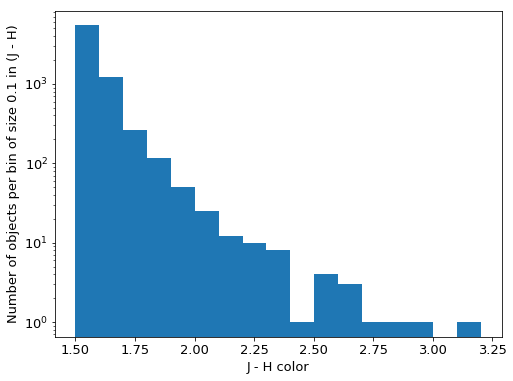

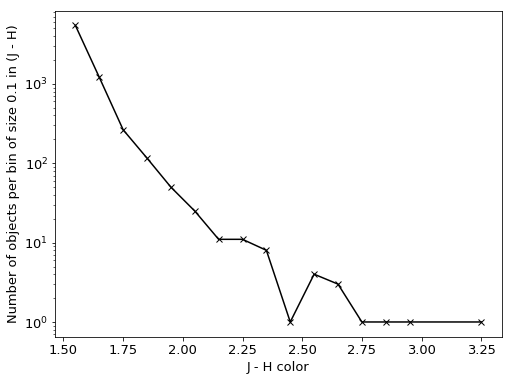

In [9]:
#R2:  Find the objects that have J-H > 1.5. 

# Extracting all of them:
r2 =   """ SELECT DataJ.StarID, DataJ.Mag1 - DataH.Mag1 AS JH FROM DataJ, DataH
            WHERE DataJ.StarID == DataH.StarID
            AND DataJ.Mag1 - DataH.Mag1 > 1.5
        """
r2ex = con.execute(r2)
r2ex = np.array(r2ex.fetchall())
print 'Number of objects found with J-H > 1.5:', len(r2ex[:,0])

# Graphical representation of results using just python:
binsize = .1
numbins = int((np.max(r2ex[:,1])-np.min(r2ex[:,1]))/binsize)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist(r2ex[:,1], bins=numbins)
#ax.text(1,1, 'Number of bins: '+str(numbins)+'\nBinsize: '+str(binsize))
ax.set_xlabel('J - H color')
ax.set_ylabel('Number of objects per bin of size 0.1 in (J - H)')
ax.set_yscale('log', nonposy='clip')
#ax.set_xlim(1,2)
#ax.set_ylim(0,130)

# Can also just count them in bins directly with SQL so not all the data has to be downloaded
# E.g. with 5 bins per unit: bins of size 1/5 unit
# Note that there is no floor function in sqlite, cast as int works the same
# but only for positive numbers! (for positive and negative numbers it is complicated)
r2_count = """
        SELECT 1/10.*(0.5 + CAST(10.* (j.Mag1 - h.Mag1) AS INT)) AS JH_Binned, 
        COUNT(j.Mag1) as num
        FROM DataJ as j, DataH as h
        WHERE j.StarID == h.StarID
        AND j.Mag1 - h.Mag1 > 1.5
        GROUP BY JH_Binned
        ORDER BY JH_Binned        
     """
r2_c_ex = con.execute(r2_count)
r2_c_ex = np.array(r2_c_ex.fetchall())

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(r2_c_ex[:,0], r2_c_ex[:,1], ls='-', marker='x', color='black')
ax.set_xlabel('J - H color')
ax.set_ylabel('Number of objects per bin of size 0.1 in (J - H)')
ax.set_yscale('log')

(23521L, 5L)
[[  0.00000000e+00   1.53819688e+04   4.71459912e+03   1.00482839e+04
    1.61894569e+02]
 [  1.00000000e+00   1.37788242e+04   5.87642090e+03   9.82762256e+03
    1.62405029e+02]
 [  2.00000000e+00   1.38110312e+04   5.61617139e+03   9.71360132e+03
    1.61756966e+02]
 ..., 
 [  3.09997000e+05   9.78291641e+04   9.31906719e+04   9.55099180e+04
    2.14320145e+02]
 [  3.09998000e+05   2.24708643e+03   2.22998975e+03   2.23853809e+03
    1.70112762e+02]
 [  3.09999000e+05   1.81348219e+05   1.07923539e+05   1.44635879e+05
    2.34052528e+02]]


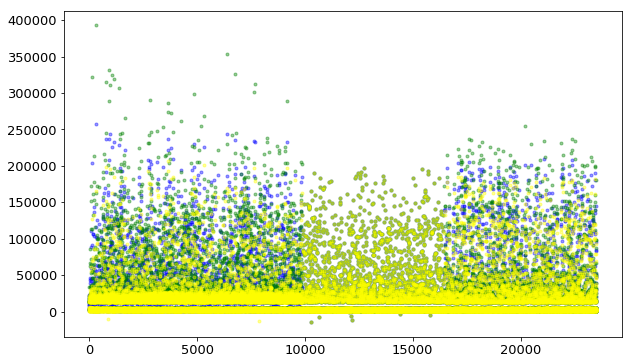

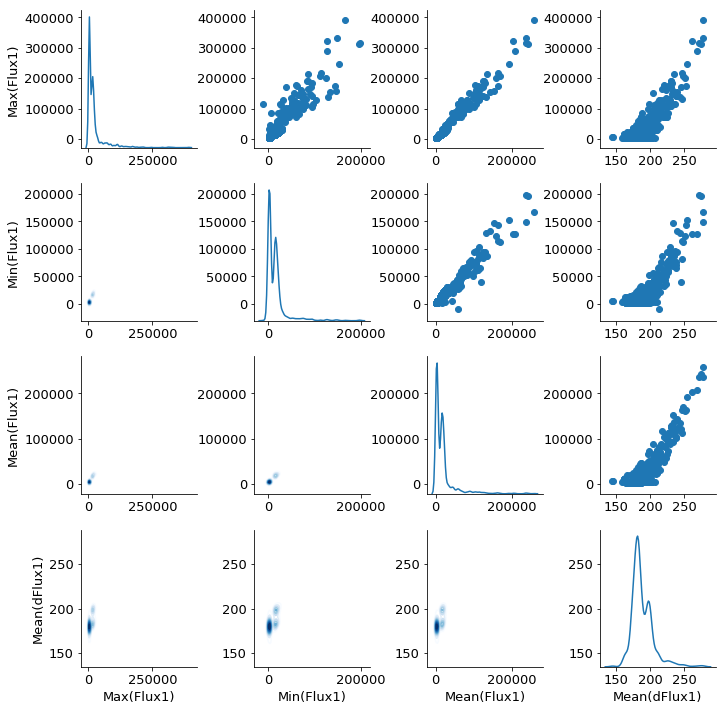

In [15]:
#R3:  Find the objects where Ks differs by more than 20 times the flux uncertainty 
#     from the mean flux. 

# This just selects all the properties of these observations, what would you want to do with them?
r3 = """
        SELECT * FROM DataKs
        WHERE ABS( Flux1 - (SELECT AVG(Flux1) FROM DataKs
        GROUP BY DataKs.StarID) ) > ABS(20*dFlux1)
        ORDER BY StarID
     """

# This selects the IDs of the objects:
r3 = """
        SELECT StarID FROM DataKs
        WHERE ABS( Flux1 - (SELECT AVG(Flux1) FROM DataKs
        GROUP BY DataKs.StarID) ) > ABS(20*dFlux1)
        GROUP BY StarID
        ORDER BY StarID
     """
    
# This selects info that can be used to visualise the data (>20K results):
r3 = """
        SELECT StarID, MAX(Flux1), MIN(Flux1), AVG(Flux1), AVG(dFlux1) 
        FROM DataKs
        WHERE ABS( Flux1 - (SELECT AVG(Flux1) FROM DataKs
        GROUP BY DataKs.StarID) ) > ABS(20*dFlux1)
        GROUP BY StarID
        ORDER BY StarID
     """
r3res = con.execute(r3)
r3res = np.array(r3res.fetchall())
print r3res.shape

print r3res

#r3res = r3res[:100]
xarray = np.linspace(0,len(r3res[:,0]), len(r3res[:,0]))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(xarray, r3res[:,3], linestyle='none', marker='.', alpha=0.4, color='blue')
ax.plot(xarray, r3res[:,1], linestyle='none', marker='.', alpha=0.4, color='green')
ax.plot(xarray, r3res[:,2], linestyle='none', marker='.', alpha=0.4, color='yellow')
# This ^ looks horrible

#res = ax.hist(r3res[:,3], 50, alpha=0.4)
#res2 = ax.hist(r3res[:,0], 50, alpha=0.4)
#res3 = ax.hist(r3res[:,1], 50, alpha=0.4)

# Try to visualise with pandas + seaborn:
# (This takes so much time!)
# (Take only 1st 1000:)
r3res = r3res[:1000]
# Also, it's quite ugly
df = pd.DataFrame(r3res, columns=['StarID', 'Max(Flux1)', 'Min(Flux1)', 'Mean(Flux1)', 'Mean(dFlux1)'])
grid = sns.PairGrid(df, diag_sharey=False, 
                    vars = ['Max(Flux1)', 'Min(Flux1)', 'Mean(Flux1)', 'Mean(dFlux1)'])
grid.map_lower(sns.kdeplot, cmap='Blues')
grid.map_upper(plt.scatter)
grid.map_diag(sns.kdeplot)    

# Note: classification differs for same StarID (can) (some classified as noise)
# But the question is to just select the objects, so I won't worry about that.
# Minstens 1 van de observaties verschillend van de mean? Dat is wat er nu gebeurt
# Of allemaal? -> Nee: smooth data zou altijd een deel gelijk moeten zijn aan de mean
# Lijkt te werken, check (SQL?) hoeveel van de sterren dit zijn!

In [10]:
# R4: Find all catalogues that exist for a given field.
field = 2
r4 = """
        SELECT Filename, FieldID FROM ObsInfo
        WHERE ObsInfo.FieldID == {}
     """.format(field)
r4res = con.execute(r4)
print 'For Field '+str(field)+', The following catalogues exist:'
for row in r4res:
    print row[0]
    
# For the report: sort them by field using this query 3 times:
fields = [1,2,3]
print
print 'Now for all existing fields:'
for field in fields:
    r4 = """
        SELECT Filename, Filter, MJD, FieldID FROM ObsInfo
        WHERE ObsInfo.FieldID == {}
         """.format(field)
    r4res = con.execute(r4)
    print 'For Field '+str(field)+', The following catalogues exist:'
    for row in r4res:
        print 'Filename:',row[0], 'Filter:', row[1], 'MJD:', row[2]
    print 


For Field 2, The following catalogues exist:
H-ADP.2017-01-18T11:58:35.780b.fits
J-ADP.2017-01-18T11:58:35.781b.fits
Ks-ADP.2016-05-25T15:33:39.546b.fits
Y-ADP.2017-01-18T11:58:36.901b.fits
Z-ADP.2017-01-18T11:58:36.905b.fits

Now for all existing fields:
For Field 1, The following catalogues exist:
Filename: H-ADP.2017-01-18T11:58:35.780.fits Filter: H MJD: 57257.044108
Filename: J-ADP.2017-01-18T11:58:35.781.fits Filter: J MJD: 57257.0504323
Filename: Ks-ADP.2017-01-18T11:58:39.907.fits Filter: Ks MJD: 56561.0020158
Filename: Ks-ADP.2016-05-25T15:33:39.546.fits Filter: Ks MJD: 56788.346937
Filename: Ks-ADP.2016-05-25T15:33:43.377.fits Filter: Ks MJD: 56829.0390512
Filename: Y-ADP.2017-01-18T11:58:36.901.fits Filter: Y MJD: 57267.1596647
Filename: Z-ADP.2017-01-18T11:58:36.905.fits Filter: Z MJD: 57267.1671072

For Field 2, The following catalogues exist:
Filename: H-ADP.2017-01-18T11:58:35.780b.fits Filter: H MJD: 57258.044108
Filename: J-ADP.2017-01-18T11:58:35.781b.fits Filter: J M

(2704L, 5L)
(4636L, 5L)


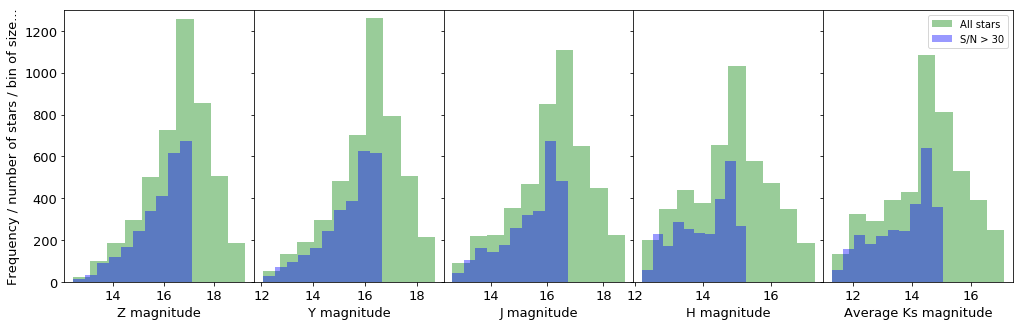

In [11]:
# R5: For a given field, retrieve the Y, Z, J, H and Ks magnitudes for all stars with S/N > 30
# in Y, Z, J, H and Ks 

givenfield = 2

# I assume we want S/N bigger in all fields! So S/N > 30 in Y, Z, J AND H
# Ks is variable, so we need to think of a different criterion for the stars 
# that are observed multiple times in the Ks band

# What I assume is: you want S/N > 30 for Y, Z, J AND H, and also for equal to or 
# more than 'fraction_sn' of the Ks data! E.g. if you observe a star 10 times in Ks, and 
# fraction_sn = 0.5, then only those stars are returned for which 50% of the Ks observations 
# have S/N > 30. For these stars, the mean Ks magnitude is returned.

# I leave x as a free parameter (but of course in pure SQL this parameter can be chosen!)

# Moreover, I assume you want at least 'fraction_class' of the Ks points with ID 'StarID' to 
# have Class -1 (identified as stars). For all the other bands, I assume this class needs to be 
# equal to -1 in any case

field = 1
fraction_sn = 1. #100% of Ks observations of the same star need S/N > 30
fraction_class = 1. #100% of Ks observations of the same star need Class == -1

r5 = """
        SELECT DataZ.Mag1, DataY.Mag1, DataJ.Mag1, DataH.Mag1, AVG(DataKs_main.Mag1)
        FROM DataZ, DataY, DataJ, DataH, DataKs AS DataKs_main, StarFields AS SF
        
        WHERE DataZ.StarID = SF.StarID AND DataY.StarID = SF.StarID AND DataJ.StarID = SF.StarID
        AND DataH.StarID = SF.StarID AND DataKs_main.StarID = SF.StarID
        AND SF.FieldID == {0}
        
        AND (DataY.Flux1/DataY.dFlux1) > 30 AND (DataZ.Flux1/DataZ.dFlux1) > 30
        AND (DataJ.Flux1/DataJ.dFlux1) > 30 AND (DataH.Flux1/DataH.dFlux1) > 30
        AND (SELECT COUNT(DataKs_sub.StarID) FROM DataKs AS DataKs_sub
                    WHERE (DataKs_sub.Flux1/DataKs_sub.dFlux1) > 30
                    AND DataKs_sub.StarID == DataKs_main.StarID) 
            >= 
            (SELECT COUNT(DataKs_sub.StarID) FROM DataKs AS DataKs_sub
                    WHERE DataKs_sub.StarID == DataKs_main.StarID)  * {1}        
        
        AND DataY.Class == -1 AND DataZ.Class == -1 AND DataJ.Class == -1 AND DataH.Class == -1
        AND (SELECT COUNT(DataKs_sub.StarID) FROM DataKs AS DataKs_sub
                    WHERE (DataKs_sub.Class) == -1
                    AND DataKs_sub.StarID == DataKs_main.StarID) 
            >= 
            (SELECT COUNT(DataKs_sub.StarID) FROM DataKs AS DataKs_sub
                    WHERE DataKs_sub.StarID == DataKs_main.StarID)  * {2}  
        
        GROUP BY SF.StarID             
     """.format(field, fraction_sn, fraction_class)

field=1
r5res = con.execute(r5)
res_crit = np.array(r5res.fetchall())
print res_crit.shape

# Visualise the data:

# Visualisation idea: compare these magnitudes (and the average Ks magnitude)
# to the magnitudes of the stars without S/N crit (keep class crit the same:)

# This query selects the magnitudes of the stars without the S/N crit:

r5_rest = """
        SELECT DataZ.Mag1, DataY.Mag1, DataJ.Mag1, DataH.Mag1, AVG(DataKs_main.Mag1)
        FROM DataZ, DataY, DataJ, DataH, DataKs AS DataKs_main, StarFields AS SF
        
        WHERE DataZ.StarID = SF.StarID AND DataY.StarID = SF.StarID AND DataJ.StarID = SF.StarID
        AND DataH.StarID = SF.StarID AND DataKs_main.StarID = SF.StarID
        AND SF.FieldID == {0}   
        
        AND DataY.Class == -1 AND DataZ.Class == -1 AND DataJ.Class == -1 AND DataH.Class == -1
        AND (SELECT COUNT(DataKs_sub.StarID) FROM DataKs AS DataKs_sub
                    WHERE (DataKs_sub.Class) == -1
                    AND DataKs_sub.StarID == DataKs_main.StarID) 
            >= 
            (SELECT COUNT(DataKs_sub.StarID) FROM DataKs AS DataKs_sub
                    WHERE DataKs_sub.StarID == DataKs_main.StarID)  * {1}  
        
        GROUP BY SF.StarID             
     """.format(field, fraction_class)

r5res = con.execute(r5_rest)
res_rest = np.array(r5res.fetchall())
print res_rest.shape

rcParams['figure.figsize'] = (17,5)
# Z, Y, J, H, K
fig, axs = plt.subplots(1,5)
fig.subplots_adjust(wspace=0)
ax = axs.ravel()

ylim = (0,1300)

ax[0].set_ylabel('Frequency / number of stars / bin of size...')

ax[0].hist(res_rest[:,0], histtype='stepfilled', color='green', alpha=0.4)
ax[0].hist(res_crit[:,0], histtype='stepfilled', color='blue', alpha=0.4)
ax[0].set_xlabel('Z magnitude')
ax[0].set_ylim(ylim)

ax[1].hist(res_rest[:,1], histtype='stepfilled', color='green', alpha=0.4)
ax[1].hist(res_crit[:,1], histtype='stepfilled', color='blue', alpha=0.4)
ax[1].set_xlabel('Y magnitude')
ax[1].set_ylim(ylim)
ax[1].set_yticklabels([])

ax[2].hist(res_rest[:,2], histtype='stepfilled', color='green', alpha=0.4)
ax[2].hist(res_crit[:,2], histtype='stepfilled', color='blue', alpha=0.4)
ax[2].set_xlabel('J magnitude')
ax[2].set_ylim(ylim)
ax[2].set_yticklabels([])

ax[3].hist(res_rest[:,3], histtype='stepfilled', color='green', alpha=0.4)
ax[3].hist(res_crit[:,3], histtype='stepfilled', color='blue', alpha=0.4)
ax[3].set_xlabel('H magnitude')
ax[3].set_ylim(ylim)
ax[3].set_yticklabels([])

ax[4].hist(res_rest[:,4], histtype='stepfilled', color='green', alpha=0.4, label='All stars')
ax[4].hist(res_crit[:,4], histtype='stepfilled', color='blue', alpha=0.4, label='S/N > 30')
ax[4].set_xlabel('Average Ks magnitude')
ax[4].set_ylim(ylim)
ax[4].set_yticklabels([])


ax[4].legend()

# It seems to work, but to be sure, does this query do what we want?
# Check with python with generic query! 
# Spoiler: gives the same output, query does what we want. See below. 

# r52 = """
#         SELECT 
#         DataZ.Flux1, DataZ.dFlux1, DataY.Flux1, DataY.dFlux1, DataJ.Flux1, DataJ.dFlux1, 
#         DataH.Flux1, DataH.dFlux1, DataKs_main.Flux1, DataKs_main.dFlux1, 
        
#         DataZ.Class, DataY.Class, DataJ.Class, DataH.Class, DataKs_main.Class,
        
#         DataKs_main.StarID,
        
#         DataZ.Mag1, DataY.Mag1, DataJ.Mag1, DataH.Mag1, DataKs_main.Mag1
#         FROM DataZ, DataY, DataJ, DataH, DataKs AS DataKs_main, StarFields AS SF
        
#         WHERE  DataZ.StarID = SF.StarID AND DataY.StarID = SF.StarID AND DataJ.StarID = SF.StarID
#         AND DataH.StarID = SF.StarID AND DataKs_main.StarID = SF.StarID
#         AND SF.FieldID == {}
#     """.format(field)

# r52res = con.execute(r52)
# res2 = np.array(r52res.fetchall()).astype(np.float64)
# print res2.shape

# snz = res2[:,0]/res2[:,1]
# sny = res2[:,2]/res2[:,3]
# snj = res2[:,4]/res2[:,5]
# snh = res2[:,6]/res2[:,7]
# snk = res2[:,8]/res2[:,9]

# classz, classy, classj, classh, classk = res2[:,10], res2[:,11], res2[:,12], res2[:,13], res2[:,14]

# crit = (snz > 30 ) & (sny > 30) & (snj > 30) & (snh > 30) & (classz == -1) & (classy == -1) & (classj == -1) & (classh == -1)
# # k criterion: x% of all k observations have snk > 30 and class == -1:
# percentage = 1.
# kid = res2[:,15]
# kids = np.unique(kid)
# kcritarr = np.zeros(len(kid), dtype=bool)
# for i, ID in enumerate(kids):
#     snk_for = snk[kid == ID]
#     class_for = classk[kid == ID]
#     #print float(len(class_for)), len(class_for[class_for == -1])
#     #print len(class_for[class_for == -1])/len(class_for)
#     if float(len(class_for[class_for == -1]))/len(class_for) >= percentage:
#         if float(len(snk_for[snk_for > 30]))/len(snk_for) >= percentage:
#         #print 'hey2'
#             kcritarr[kid == ID] = True

# #critk = (snk > 30) & (classk == -1)
# res2 = res2[crit & kcritarr]

# kid2 = kid[crit & kcritarr]
# print kid2.shape
# print np.unique(kid2).shape #> this is the python output: finds the same number of stars!

# Euclid space mission simulations

The Euclid space mission will have three filters: Y, J, and H. For planning purposes a colleague
asks you to use your database to create simulated stars for Euclid. Use the distribution of your
sample of star in Y-J, J-H space to create a new sample of 100,000 stars for him to use as simulation
sample for Euclid. Make sure to carefully justify the choices you make. Display the result as
a 2D distribution function in the Y-J, J-H plane.